In [1]:
#<api>
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as D
from torch.autograd import Variable

import matplotlib
import matplotlib.pyplot as plt
from jupyter_cms.loader import load_notebook

%matplotlib inline

In [2]:
# <api>
import os
path = os.getcwd()
s = '/'
pardir = s.join(path.split(s)[:-1])

# Load source notebooks
trgt = load_notebook(str(pardir + '/widgets/Widget_targets.ipynb'))
widget_methods = load_notebook(str(pardir + '/widgets/Widget_methods.ipynb'))

## Network class

In [3]:
#<api>
class MLP(nn.Module):
    '''
    Multilayer Perceptron network consisting of an input layer with 2 units, 
    a number of hidden layers (specified by the user) and an output layer 
    with one unit. All hidden layers have the same number of units (also 
    specified by user). All activation functions are non-linear relu functions.
    '''

    def __init__(self, n_hidden_layers, n_in_array, n_out_array):
        
        super(MLP, self).__init__()
        
        self.layers = nn.ModuleList()
        for l_ID in np.arange(0, n_hidden_layers):
            self.layers.append(nn.Linear(n_in_array[l_ID], n_out_array[l_ID], bias=True))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(n_in_array[-1], n_out_array[-1], bias=True))
        
    def forward(self, x):
        '''
        Forward pass of network.
        '''
        for layer in self.layers:
            x = layer(x)
        
        return x

## Full MLP DrawingMethod

In [4]:
#<api>
class MLP_DrawingMethod(widget_methods.DrawingMethod):
    '''
    Class to create an MLP network, train the network on given samples,
    compute the visualization, importantly implements the draw() method 
    of the parent classe DrawingMethod.
    '''

    def __init__(self, target=trgt.MLP_target(), batch_size=1, n_in=2, n_out=1, 
                 n_hidden_layers=1, n_hidden_units=2, lr=0.01, epochs=1):
        '''
        Initialization. Receives parameters, initializes network, optimizer 
        and optimization criterion and samples from the target distribution.
        '''    
        
        self.target = target
        self.batch_size = batch_size
        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden_layers = n_hidden_layers
        self.n_hidden_units = n_hidden_units
        self.lr = lr
        self.epochs = epochs
        self.size = target.get_size()
        
        # initialize network
        self.set_model()
        # initialize optimizer
        self.set_optim()
                
        # set loss criterion
        self.criterion = nn.MSELoss(reduction='elementwise_mean')
       
        # get data
        data = self.target.get_samples()
        self.data_samples = np.empty((len(data['x']), 2))
        self.data_samples[:,0] = data['x']
        self.data_samples[:,1] = data['y']
        self.data_classes = data['z']

    def set_dataloader(self, data_samples, data_classes):
        '''
        Sets the dataloader for the training data.
        '''
        # create data loader
        data_samples = torch.from_numpy(data_samples).float()
        data_classes = torch.from_numpy(data_classes).float()

        train_dataset = D.TensorDataset(data_samples, data_classes.unsqueeze(1))
        
        self.trainloader = D.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

    def set_viz_dataloader(self):
        '''
        Sets the dataloader for the meshgrid.
        '''
        # grid for visualization
        self.xx, self.yy = np.meshgrid(np.arange(-self.size, self.size, 0.05),
                                         np.arange(-self.size, self.size, 0.05))
        self.xx_yy = np.column_stack((self.xx.ravel(), self.yy.ravel()))
        
        vis_dataset = D.TensorDataset(torch.from_numpy(self.xx_yy).float().unsqueeze(1))
        
        self.vis_dataloader = D.DataLoader(vis_dataset, batch_size=self.xx_yy.shape[0], shuffle=False)

    def set_model(self):
        '''
        Sets the network architecture.
        '''
        # array of the number of inputs to each layer (hidden and output layer)
        self.n_in_array = np.concatenate(([self.n_in], np.ones(self.n_hidden_layers)\
                                          *self.n_hidden_units)).astype('int')
        # array of the number of units in each layer (hidden and output layer)
        self.n_out_array = np.concatenate((np.ones(self.n_hidden_layers)\
                                           *self.n_hidden_units, [self.n_out])).astype('int')
        self.model = MLP(self.n_hidden_layers, self.n_in_array, self.n_out_array)

    def set_optim(self):
        '''
        Sets the optimizer. Must be implemented by every subclass.
        '''
        pass
    
    def perform_learn(self):
        '''
        Iterates over training data and optimizes model parameters.
        '''
        
        errors = []
        separatrix = []
        
        for e in range(self.epochs):
            for i, (inputs, label) in enumerate(self.trainloader): 
                self.optim.zero_grad()   # zero the parameter gradients

                output = self.model(inputs)

                loss = self.criterion(output, label)

                loss.backward()
                self.optim.step()    # Does the update

                errors.append(loss.item())

                if i%10 == 0:
                    s = self.comp_separatrix()
                    separatrix.append(s)
                    

        s = self.comp_separatrix()
        separatrix.append(s)

        return errors, separatrix
    
    def comp_separatrix(self):
        '''
        Computes the separatrix given the current network state.
        '''
    
        Z = np.array([self.model(inp[0]) for i, inp in enumerate(self.vis_dataloader)])        
        Z = np.squeeze(Z[0].detach().numpy())
        Z = Z.reshape(self.xx.shape)
        return Z
    
    def draw(self):
        '''
        Resets the model and optimizer, performs learning the parameters 
        and computing the separatrix of the optimized model.
        '''
        # set data loaders for training data and visualization grid
        self.set_dataloader(self.data_samples, self.data_classes)
        self.set_viz_dataloader()
        
        # reset model and optimizer
        self.set_model()
        self.set_optim()
        
        self.errors, self.separatrix = self.perform_learn()
        return {'errors' : self.errors, 'separatrix' : self.separatrix}   
    
    def set_param(self, param_dict):
        '''
        Allows to set additional parameters, given from extra_widget.
        '''
        for i in param_dict:
            if i=='layers':
                self.n_hidden_layers = param_dict['layers']
            elif i=='units':
                self.n_hidden_units = param_dict['units']
            elif i =='lr':
                self.lr = param_dict['lr']
            elif i =='epochs':
                self.epochs = param_dict['epochs']
            elif i =='batch':
                self.batch_size = param_dict['batch']
            elif i=='target':
                self.target = param_dict['target']
            elif i=='gamma':
                self.gamma = param_dict['gamma']
            elif i=='beta1':
                self.beta1 = param_dict['beta1']
            elif i=='beta2':
                self.beta2 = param_dict['beta2']
            elif i=='stochastic':
                self.stochastic = param_dict['stochastic']

## Various Optimizer DrawingMethods

In [5]:
#<api>
class MLP_Vanilla_DrawingMethod(MLP_DrawingMethod):
    '''
    Class for the MLP with the vanilla stochastic gradient descent optimizer.
    '''
    def set_optim(self):
        self.optim = optim.SGD(self.model.parameters(), lr=self.lr, momentum=0., weight_decay=0)

In [6]:
#<api>
class MLP_Momentum_DrawingMethod(MLP_DrawingMethod):
    '''
    Class for the MLP with the momentum stochastic gradient descent optimizer.
    '''
    def __init__(self, target=trgt.MLP_target(), batch_size=1, n_in=2, n_out=1, 
                 n_hidden_layers=1, n_hidden_units=2, lr=0.01, epochs=1, gamma=0.9):
        
        self.gamma = gamma
        
        super(MLP_Momentum_DrawingMethod, self).__init__(target, batch_size, n_in, n_out, 
                                                         n_hidden_layers, n_hidden_units, lr, epochs)
    
    def set_optim(self):
        self.optim = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.gamma, weight_decay=0)

In [7]:
#<api>
class MLP_Nesterov_DrawingMethod(MLP_DrawingMethod):
    '''
    Class for the MLP with the Nesterov stochastic gradient descent optimizer.
    '''
    def __init__(self, target=trgt.MLP_target(), batch_size=1, n_in=2, n_out=1, 
                 n_hidden_layers=1, n_hidden_units=2, lr=0.01, epochs=1, gamma=0.9):
        
        self.gamma = gamma
        
        super(MLP_Nesterov_DrawingMethod, self).__init__(target, batch_size, n_in, n_out, 
                                                         n_hidden_layers, n_hidden_units, lr, epochs)
    
    def set_optim(self):
        self.optim = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.gamma, 
                               nesterov=True, weight_decay=0)

In [8]:
#<api>
class MLP_Adagrad_DrawingMethod(MLP_DrawingMethod):
    '''
    Class for the MLP with the Adagrad optimizer.
    '''
    def set_optim(self):
        self.optim = optim.Adagrad(self.model.parameters(), lr=self.lr, 
                                   weight_decay=0, initial_accumulator_value=0)

In [15]:
#<api>
class MLP_RMSProp_DrawingMethod(MLP_DrawingMethod):
    '''
    Class for the MLP with RMSProp optimizer.
    '''
    def __init__(self, target=trgt.MLP_target(), batch_size=1, n_in=2, n_out=1, 
                 n_hidden_layers=1, n_hidden_units=2, lr=0.01, epochs=1, gamma=0.99, eps=1e-08):
        
        self.gamma = gamma
        self.eps = eps
        
        super(MLP_RMSProp_DrawingMethod, self).__init__(target, batch_size, n_in, n_out, 
                                                         n_hidden_layers, n_hidden_units, lr, epochs)
    
    def set_optim(self):
        self.optim = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=self.gamma, eps=self.eps,
                                   weight_decay=0, momentum=0, centered=False)

In [16]:
#<api>
class MLP_Adam_DrawingMethod(MLP_DrawingMethod):
    '''
    Class for the MLP with ADAM optimizer.
    '''
    def __init__(self, target=trgt.MLP_target(), batch_size=1, n_in=2, n_out=1, 
                 n_hidden_layers=1, n_hidden_units=2, lr=0.01, epochs=1, beta1=0.9, beta2=0.999, eps=1e-08):
        
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        
        super(MLP_Adam_DrawingMethod, self).__init__(target, batch_size, n_in, n_out, 
                                                         n_hidden_layers, n_hidden_units, lr, epochs)
    
    def set_optim(self):
        self.optim = optim.Adam(self.model.parameters(), lr=self.lr, betas=(self.beta1, self.beta1), 
                                eps=self.eps, weight_decay=0, amsgrad=False)

## Initialize and train MLP

In [11]:
target = trgt.MLP_target(mean1=[-0.5, 0.5], cov1=[[0.2, 0.],[0., 0.2]], 
                         mean2=[0.5, -0.5], cov2=[[0.2, 0.],[0., 0.2]],
                         n_samples_per_class=100)

mlp_dm = MLP_Nesterov_DrawingMethod(target=target, n_in=2, n_out=1, batch_size=1, 
                                n_hidden_layers=1, n_hidden_units=3, lr=0.005, epochs=1)

In [12]:
dict_results = mlp_dm.draw()

errors = dict_results['errors']
separatrix = dict_results['separatrix']

## Visualize results

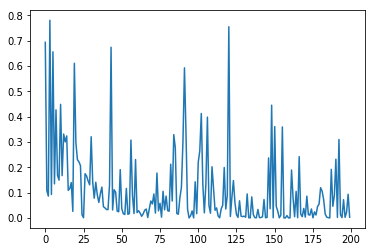

In [13]:
# plot errors
plt.figure()
plt.plot(errors)

Text(0, 0.5, 'feature 2')

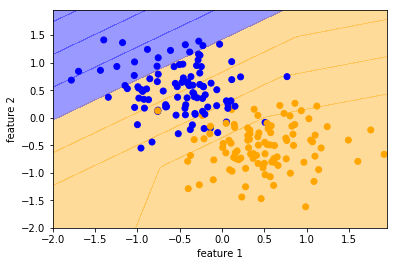

In [14]:
# plot separatrix
plt.figure()
colors = ['orange', 'blue']
plt.contourf(mlp_dm.xx, mlp_dm.yy, separatrix[-1], alpha=0.4, 
                 cmap=matplotlib.colors.ListedColormap(colors))
plt.scatter(mlp_dm.data_samples[:, 0], mlp_dm.data_samples[:, 1], c=mlp_dm.data_classes, 
                cmap=matplotlib.colors.ListedColormap(colors))
#plt.xlim([-1,2])
#plt.ylim([-1,2])
plt.xlabel('feature 1')
plt.ylabel('feature 2')